# NYC → Key West: Actual Days & Daily Miles from Odometer

This notebook takes the **end-of-day odometer (cumulative miles)** and computes the **daily miles**
and the **actual number of days** it took. It also aligns the final total to **1,664.9 mi** and can
estimate hours/day if the total riding time (~145 hr) is provided.

> Example: entries `55, 120` mean **Day 1 = 55 mi**, **Day 2 = 65 mi**.


## 1) Setup


In [11]:
import math
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 2)

## 2)Cumulative odometer readings

In [12]:
# Cumulative miles at the end of each day
cumulative = [55, 120, 190, 260, 330, 405, 485, 560, 640, 725,
              795, 865, 930, 1000, 1065, 1130, 1195, 1260, 1330, 1400,
              1470, 1535, 1595]

EXPECTED_TOTAL = 1664.9  # miles NYC → Key West
TOTAL_HOURS    = 145     # optional total riding hours (for estimated hours/day)

## 3) Build Series, validate, and align to target total (1,664.9 mi)
- Make the Series indexed by **Day** (1..N)
- Ensure cumulative is non-decreasing
- If your last entry isn't exactly 1,664.9, we **adjust** the last day (or **append** a final day) to end exactly at the target total

In [13]:
cum = pd.Series(cumulative, name="CumulativeMiles")
cum.index = pd.RangeIndex(start=1, stop=len(cum)+1, name="Day")

# Validate non-decreasing (allow equal for rest days)
if not cum.is_monotonic_increasing:
    raise ValueError("Cumulative miles must be non-decreasing (rest days can repeat).")

# Align final cumulative to EXPECTED_TOTAL exactly
current_total = float(cum.iloc[-1])
tol = 1e-6
if abs(current_total - EXPECTED_TOTAL) > tol:
    if current_total < EXPECTED_TOTAL:
        # Append a final day to reach the target
        cum.loc[cum.index[-1] + 1] = EXPECTED_TOTAL
        note = f"Added Day {cum.index[-1]} to reach {EXPECTED_TOTAL} mi."
    else:
        # Trim down the last day to end exactly at the target
        cum.iloc[-1] = EXPECTED_TOTAL
        note = f"Adjusted last day to end at {EXPECTED_TOTAL} mi (was {current_total})."
else:
    note = "Cumulative already equals 1,664.9 mi."

note

'Added Day 24 to reach 1664.9 mi.'

## 4) Compute daily miles and (optionally) hours per day
- `DailyMiles = diff(cumulative)`, with Day 1 equal to the first cumulative value
- If `TOTAL_HOURS` is provided, estimate `EstHours = DailyMiles / avg_mph`, where `avg_mph = EXPECTED_TOTAL / TOTAL_HOURS`

In [14]:
daily = cum.diff().fillna(cum.iloc[0]).rename("DailyMiles")

# Estimated hours per day based on average trip speed
avg_mph = EXPECTED_TOTAL / TOTAL_HOURS if TOTAL_HOURS else None

df = pd.concat([cum, daily], axis=1)
if avg_mph:
    df["EstHours"] = (df["DailyMiles"] / avg_mph).round(2)
    df["CumulativeHours"] = df["EstHours"].cumsum().round(2)

# Round miles for display
out = df.copy()
out["DailyMiles"] = out["DailyMiles"].round(2)
out["CumulativeMiles"] = out["CumulativeMiles"].round(1)
out

,CumulativeMiles,DailyMiles,EstHours,CumulativeHours
Day,,,,
1,55.0,55.0,4.79,4.79
2,120.0,65.0,5.66,10.45
3,190.0,70.0,6.10,16.55
4,260.0,70.0,6.10,22.65
5,330.0,70.0,6.10,28.75
6,405.0,75.0,6.53,35.28
7,485.0,80.0,6.97,42.25
8,560.0,75.0,6.53,48.78
9,640.0,80.0,6.97,55.75


## 5) Summary
We print the **actual number of days** and key stats.

In [15]:
days = int(len(df))
total_miles = float(df["CumulativeMiles"].iloc[-1])
avg_daily = df["DailyMiles"].mean()
biggest_day_n = int(df["DailyMiles"].idxmax())
biggest_day_m = float(df["DailyMiles"].max())

print(f"It took {days} days to ride {total_miles:.1f} miles from NYC to Key West.")
print(f"Average miles/day: {avg_daily:.2f}")
print(f"Biggest day: Day {biggest_day_n} with {biggest_day_m:.2f} miles")
if avg_mph:
    print(f"Average speed (trip-level): {avg_mph:.2f} mph → target hours: {TOTAL_HOURS} hr")
    print(f"Estimated total hours from daily breakdown: {df['EstHours'].sum():.2f} hr")

It took 24 days to ride 1664.9 miles from NYC to Key West.
Average miles/day: 69.37
Biggest day: Day 10 with 85.00 miles
Average speed (trip-level): 11.48 mph → target hours: 145 hr
Estimated total hours from daily breakdown: 145.03 hr


## 6) Visualize
Separate plots for daily miles and cumulative miles (single-plot charts, default colors).

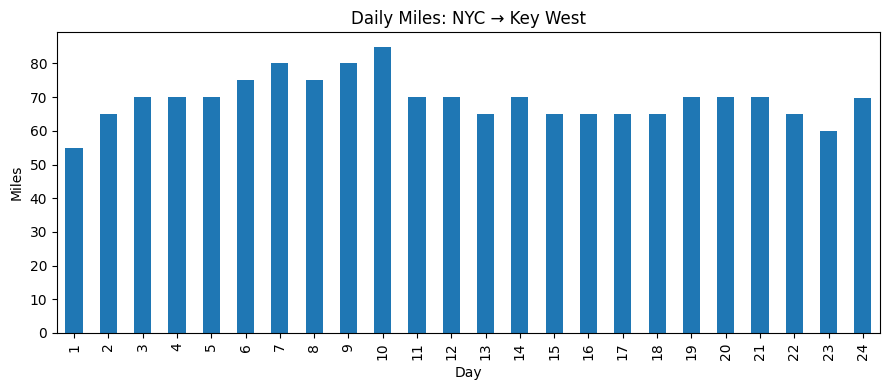

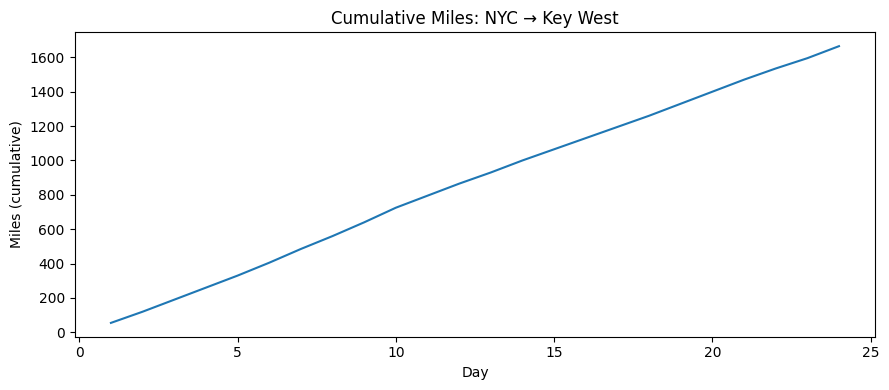

In [16]:
plt.figure(figsize=(9,4))
df["DailyMiles"].plot(kind="bar")
plt.title("Daily Miles: NYC → Key West")
plt.xlabel("Day")
plt.ylabel("Miles")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
df["CumulativeMiles"].plot()
plt.title("Cumulative Miles: NYC → Key West")
plt.xlabel("Day")
plt.ylabel("Miles (cumulative)")
plt.tight_layout()
plt.show()